# Paid retention curves


## Fake data

In [3]:
import pandas as pd
import numpy as np
from faker import Faker

def create_data(num_customers=1000):
    fake = Faker()
    np.random.seed(42)
    
    customer_data = []
    
    for _ in range(num_customers):
        customer_id = fake.uuid4()
        start_date = fake.date_between(start_date='-4y', end_date='today')
        paid_conversion_date = fake.date_between(start_date=start_date, end_date='today')
        churn_date = fake.date_between(start_date=paid_conversion_date, end_date='today') if np.random.rand() > 0.5 else None
        
        dim_1 = fake.random_int(min=1, max=5)
        dim_2 = fake.random_element(elements=('A', 'B', 'C', 'D', 'E'))
        dim_3 = fake.random_number(digits=2)
        
        customer_data.append([
            customer_id,
            paid_conversion_date,
            churn_date,
            dim_1,
            dim_2,
            dim_3
        ])
    
    columns = ['customer_id', 'paid_conversion_date', 'churn_date', 'dim_1', 'dim_2', 'dim_3']
    return pd.DataFrame(customer_data, columns=columns)

# Generate the data
data = create_data()
data

,customer_id,paid_conversion_date,churn_date,dim_1,dim_2,dim_3
0,bcb5f72b-53db-440b-894c-b0c9e84cbb14,2023-12-07,None,2,E,35
1,020568f6-d97c-4a23-8d97-af3b072fc007,2023-07-23,2023-12-26,1,B,60
2,cafb9ca1-06c9-4075-99c7-73faaa69616b,2023-06-01,2023-09-22,3,A,63
3,3f9edddd-6f17-49fb-b087-96c8da84352b,2024-01-14,2024-05-13,2,A,9
4,a8ca9a63-30f2-4edf-ab9b-e5ee44cd9cf6,2024-06-10,None,2,C,44
...,...,...,...,...,...,...
995,5e865b25-06f1-4beb-9a06-867016488fff,2021-09-22,None,5,B,87
996,95bb1114-ab8d-4cb8-bd5b-cade04bb797c,2023-03-12,2023-08-10,1,B,98
997,f0128fcc-482d-47e2-aee2-48b70f08bd08,2023-11-17,None,1,A,0
998,f5b5b35d-4d82-4ba3-8d57-696c2c3f2d02,2023-09-09,2023-09-19,4,E,33


## Survival function (Kaplan-Meier)

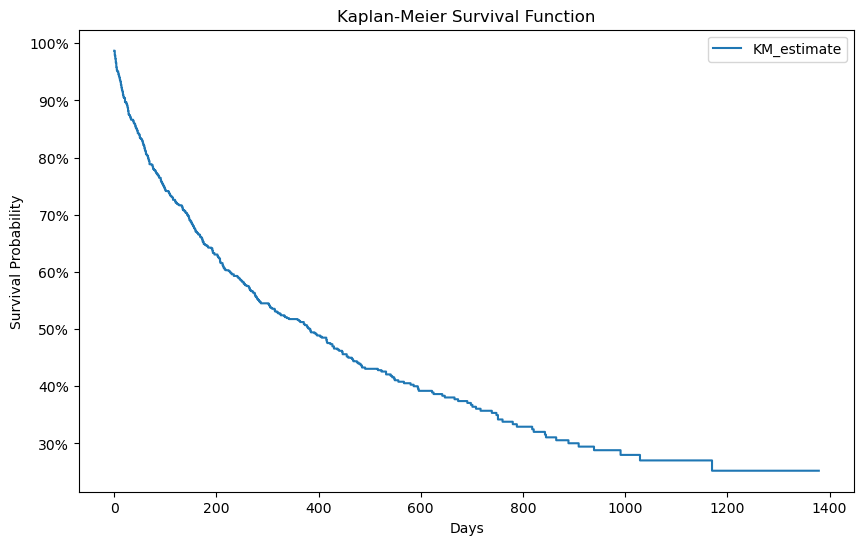

In [18]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def survival_function_km(data, paid_conversion_date_col, churn_date_col, dim=None, se=False):
    kmf = KaplanMeierFitter()
    
    # Calculate duration and event observed
    data[churn_date_col] = pd.to_datetime(data[churn_date_col], errors='coerce')
    data[paid_conversion_date_col] = pd.to_datetime(data[paid_conversion_date_col], errors='coerce')
    
    data['event_observed'] = data[churn_date_col].notnull().astype(int)
    data['duration'] = (data[churn_date_col].fillna(pd.Timestamp('today')) - data[paid_conversion_date_col]).dt.days
    
    plt.figure(figsize=(10, 6))
    
    if dim:
        # Stratify by dimension
        groups = data[dim].unique()
        for group in groups:
            group_data = data[data[dim] == group]
            kmf.fit(durations=group_data['duration'], event_observed=group_data['event_observed'], label=str(group))
            kmf.plot_survival_function(ci_show=se)
    else:
        # Single Kaplan-Meier curve
        kmf.fit(durations=data['duration'], event_observed=data['event_observed'])
        kmf.plot_survival_function(ci_show=se)
    
    plt.title('Kaplan-Meier Survival Function')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend(title=dim)
    plt.show()

# Example usage
survival_function_km(data, paid_conversion_date_col='paid_conversion_date', churn_date_col='churn_date', dim=None, se=False)

## Survival function (Exponential)

Lambda (monthly hazard rate) for group 2: 0.0588
Lambda (monthly hazard rate) for group 1: 0.0594
Lambda (monthly hazard rate) for group 3: 0.0506
Lambda (monthly hazard rate) for group 4: 0.0615
Lambda (monthly hazard rate) for group 5: 0.0408


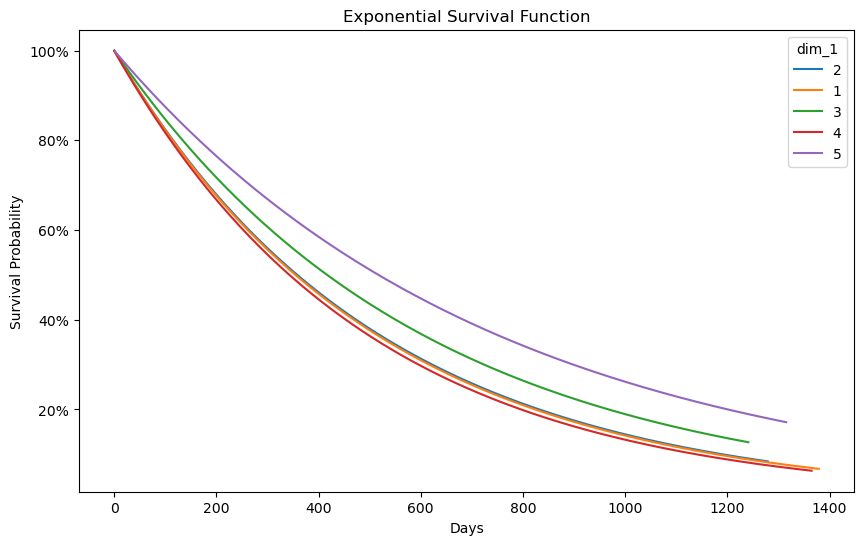

In [34]:
import pandas as pd
from lifelines import ExponentialFitter
import matplotlib.pyplot as plt

def survival_function_exp(data, paid_conversion_date_col, churn_date_col, dim=None, se=False):
    exp_fitter = ExponentialFitter()
    
    # Calculate duration and event observed
    data[churn_date_col] = pd.to_datetime(data[churn_date_col], errors='coerce')
    data[paid_conversion_date_col] = pd.to_datetime(data[paid_conversion_date_col], errors='coerce')
    
    data['event_observed'] = data[churn_date_col].notnull().astype(int)
    data['duration'] = (data[churn_date_col].fillna(pd.Timestamp('today')) - data[paid_conversion_date_col]).dt.days
    
    # Add a small positive value to zero durations
    data['duration'] = data['duration'].apply(lambda x: x if x > 0 else 0.1)
    
    plt.figure(figsize=(10, 6))
    
    if dim:
        # Stratify by dimension
        groups = data[dim].unique()
        for group in groups:
            group_data = data[data[dim] == group]
            exp_fitter.fit(durations=group_data['duration'], event_observed=group_data['event_observed'], label=str(group))
            print(f"Lambda (monthly hazard rate) for group {group}: {30.4 * 1 / exp_fitter.lambda_:.4f}")
            exp_fitter.plot_survival_function(ci_show=se)
    else:
        # Single Exponential curve
        exp_fitter.fit(durations=data['duration'], event_observed=data['event_observed'])
        print(f"Lambda (daily hazard rate) for overall data: {30.4 * 1 / exp_fitter.lambda_:.4f}")
        exp_fitter.plot_survival_function(ci_show=se)
    
    plt.title('Exponential Survival Function')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend(title=dim)
    plt.show()


survival_function_exp(data, paid_conversion_date_col='paid_conversion_date', churn_date_col='churn_date', dim='dim_1', se=False)